# Facial Expression Recognition (FER)

**Author:** [Maazouz AbdElAziz](https://github.com/AbdElAziz-Maazouz)

This notebook implements a Facial Expression Recognition system using deep learning with the CK+ dataset.

## Environment Setup
Installing required packages for the project. We'll use the `datasets` library to load our facial expression dataset.

In [1]:
# Install required packages
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:


## Data Loading
Loading the CK+ (Extended Cohn-Kanade) dataset, which contains facial expression images labeled with different emotions.
The dataset is loaded using the Hugging Face datasets library.

In [2]:
from datasets import load_dataset

# Load the CK+ dataset
ds = load_dataset("AlirezaF138/ckplus-dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/981 [00:00<?, ? examples/s]

## Dataset Overview
Examining the structure of our dataset to understand its composition:
- Number of samples
- Features available
- Data organization

In [3]:
# Display dataset information
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'file'],
        num_rows: 981
    })
})


## Data Visualization
Displaying sample images from the dataset to visualize different facial expressions.
The function shows 5 random images with their corresponding emotion labels.

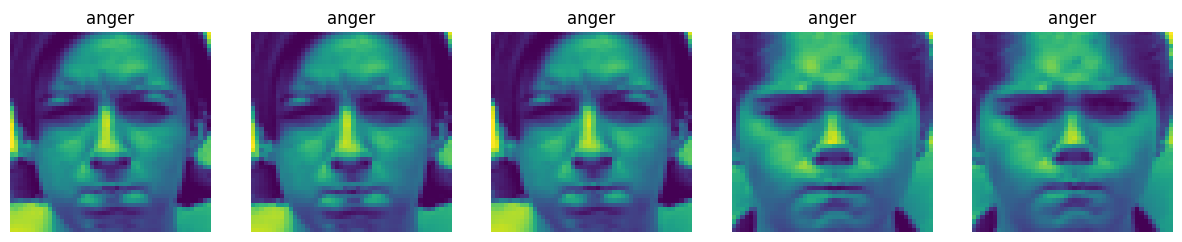

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataset, num_images=5):
    """Display sample images from the dataset with their labels.

    Args:
        dataset: The loaded dataset
        num_images: Number of images to display
    """
    train_dataset = dataset['train']
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image = train_dataset[i]['image']
        label = train_dataset[i]['label']
        axes[i].imshow(np.array(image))
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

# Display sample images
show_images(ds)

In [5]:
# Display some information about labels
labels = ds['train']['label']
unique_labels = set(labels)
print(f"Number of unique emotions : {len(unique_labels)}")
print("Unique emotions : ", unique_labels)

Number of unique emotions : 7
Unique emotions :  {'contempt', 'surprise', 'anger', 'disgust', 'happy', 'fear', 'sadness'}


In [7]:
# Count the number of images per emotion class to explore the balance of the dataset
from collections import Counter # Import the Counter class from collections module
label_counts = Counter(ds['train']['label'])
print("Distribution of labels in the training dataset:", label_counts)

Distribution of labels in the training dataset: Counter({'surprise': 249, 'happy': 207, 'disgust': 177, 'anger': 135, 'sadness': 84, 'fear': 75, 'contempt': 54})


## Data Preprocessing


In [8]:
# Prétraitement des images (conversion et redimensionnement)
def preprocess_images(dataset, target_size=(224, 224)):
    images = []
    labels = []
    for example in dataset:
        image = example['image'].convert('RGB')  # Assurer que l'image est en RGB
        image = image.resize(target_size)  # Redimensionnement de l'image
        images.append(np.array(image) / 255.0)  # Normalisation
        labels.append(example['label'])
    return np.array(images), np.array(labels)

# Conversion des images du dataset d'entraînement
train_images, train_labels = preprocess_images(ds['train'])

# Convertir les labels en format one-hot (émotions)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels_one_hot = np.eye(len(label_encoder.classes_))[train_labels_encoded]

Splitting the dataset into training and validation sets using sklearn's train_test_split function.

In [9]:
from sklearn.model_selection import train_test_split

# Split data for validation
train_images, val_images, train_labels_one_hot, val_labels_one_hot = train_test_split(
    train_images, train_labels_one_hot, test_size=0.2, random_state=42
)

## Model Architecture
Creating our facial expression recognition model using VGG16 as the base architecture:
- Using pre-trained VGG16 weights from ImageNet
- Removing the top layers
- Adding custom classification layers for emotion recognition

In [10]:
from keras.applications import VGG16

# Create base model with VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## Model Construction
Building the complete model by adding custom layers on top of VGG16 for facial expression classification.

In [11]:
from keras import layers, models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())  # Flatten VGG16 output
model.add(layers.Dense(512, activation='relu'))  # Dense layer with ReLU
model.add(layers.Dense(7, activation='softmax'))  # Output for 7 emotions

# Freeze VGG16 layers
conv_base.trainable = False

## Model Compilation
Configuring the model with appropriate optimizer, loss function, and metrics for training.

In [12]:
from keras.optimizers import Adam

# Compile model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 27563847 (105.15 MB)
Trainable params: 12849159 (49.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## Model Training
Training the model with the following configuration:
- Optimizer: Adam
- Loss: Categorical Crossentropy
- Metrics: Accuracy
- Training for 5 epochs with batch size of 32

In [13]:
# Train the model
history = model.fit(
    train_images,
    train_labels_one_hot,
    epochs=5,
    batch_size=32,
    validation_data=(val_images, val_labels_one_hot)
)

Epoch 1/5
25/25 [==============================] - 226s 9s/step - loss: 3.7034 - accuracy: 0.5357 - val_loss: 0.5991 - val_accuracy: 0.8173
Epoch 2/5
25/25 [==============================] - 221s 9s/step - loss: 0.3737 - accuracy: 0.8724 - val_loss: 0.2796 - val_accuracy: 0.9289
Epoch 3/5
25/25 [==============================] - 221s 9s/step - loss: 0.1568 - accuracy: 0.9719 - val_loss: 0.1745 - val_accuracy: 0.9746
Epoch 4/5
25/25 [==============================] - 221s 9s/step - loss: 0.0859 - accuracy: 0.9885 - val_loss: 0.1238 - val_accuracy: 0.9695
Epoch 5/5
25/25 [==============================] - 220s 9s/step - loss: 0.0533 - accuracy: 0.9962 - val_loss: 0.0716 - val_accuracy: 1.0000


## Training Performance Visualization
Plotting the training and validation metrics:
- Loss curves
- Accuracy curves
to evaluate model performance and check for overfitting

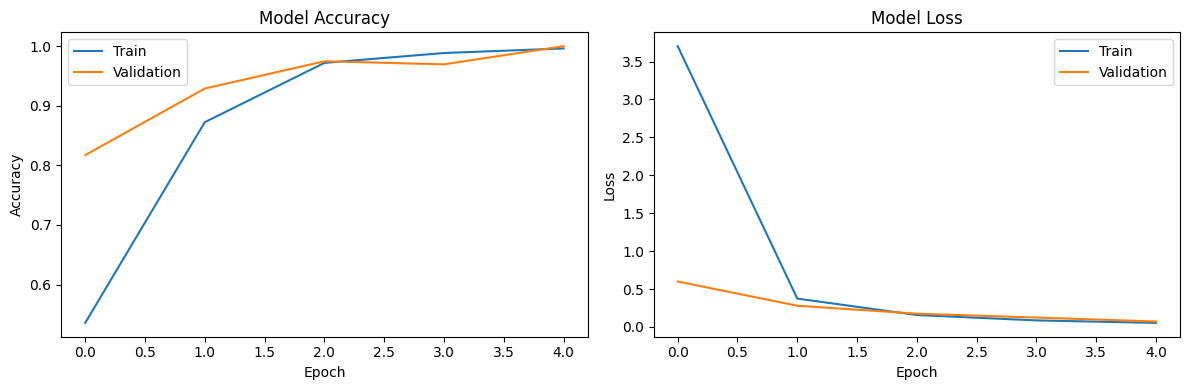

In [14]:
def plot_history(history):
    """Plot training history showing loss and accuracy curves.

    Args:
        history: Training history from model.fit()
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot training & validation loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

## Model Evaluation
Testing the model's performance on validation images:
- Visualizing predictions on 10 sample images
- Comparing predicted vs true emotions
- Displaying results in a grid layout for easy comparison

1/1 [==============================] - 3s 3s/step


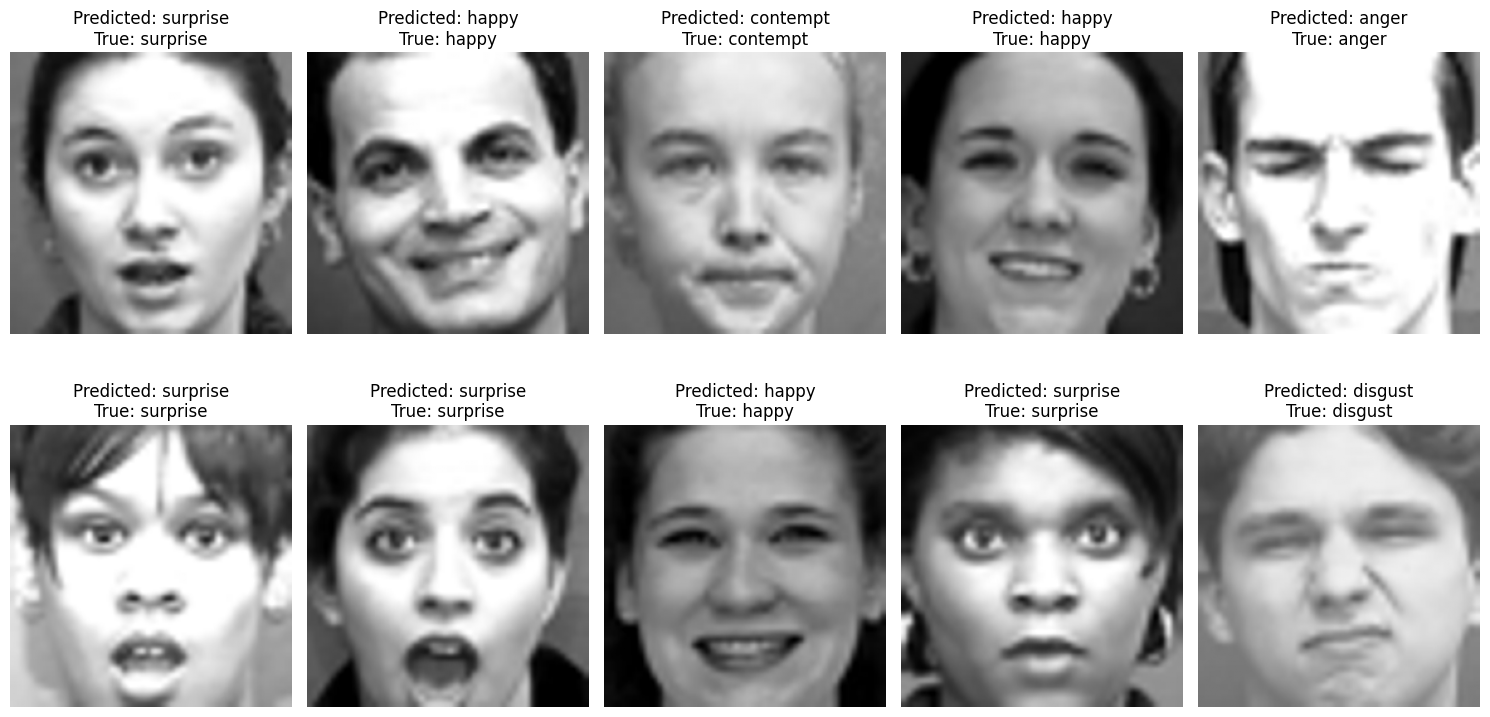

In [15]:
# Function to predict emotions on test images
def test_images(model, images, labels, label_encoder, num_images=10):
    """Test model predictions on sample images and visualize results.

    Args:
        model: Trained keras model
        images: Test image set
        labels: True labels
        label_encoder: LabelEncoder for converting between numeric and text labels
        num_images: Number of images to test (default: 10)
    """
    # Select subset of test images
    test_images = images[:num_images]
    test_labels = labels[:num_images]

    # Make predictions
    predictions = model.predict(test_images)

    # Convert predictions to labels
    predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
    true_labels = label_encoder.inverse_transform(np.argmax(test_labels, axis=1))

    # Display results
    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 8))
    axes = axes.flatten()

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(test_images[i])
        ax.set_title(f"Predicted: {predicted_labels[i]}\nTrue: {true_labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Test on validation images
test_images(model, val_images, val_labels_one_hot, label_encoder, num_images=10)

## Model Saving
Saving the trained model to disk for future use:
- Model architecture
- Trained weights
- Optimizer state

In [16]:
# Save the trained model
model.save('emotion_recognition_model.h5')
print("Model saved successfully!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!
